In [1]:
%matplotlib inline

import os, sys
import seaborn
import pandas as pd
import numpy as np
import stochastic
from scipy import stats
from matplotlib import pyplot as plt
import graphs
plt.rcParams['figure.figsize'] = [10, 6]
import matplotlib.style as style
style.use('ggplot')

def load_data(res_dir):
    data = pd.DataFrame()
    for filename in os.listdir(res_dir):
        if ".csv" in filename:
            data = pd.concat([data, pd.read_csv(os.path.join(res_dir, filename))])
            
    # exclude three acyclic graphs that might be included by accident
    data = data[~(data.graph_name.str.contains("VEGF") |
                          data.graph_name.str.contains("Toll Pathway") | data.graph_name.str.contains("Processing of Spz"))]

    return data

def extract_mean_scores_data(list_data):
    res_data = list_data.copy()
    score_cols = [col for col in res_data.columns if "scores" in col]
    res_data[score_cols] = res_data[score_cols].apply(lambda col: col.apply(
        lambda val_list: np.nanmean(eval(str(val_list).replace("nan", "np.nan")))), axis=1)
    return res_data
    
def extract_vertex_scores_data(list_data):
    res_data = []
    score_cols = [col for col in list_data.columns if "scores" in col]
    non_score_cols = [col for col in list_data if col not in score_cols]
    for index, row in list_data.iterrows():
        val_lists = [eval(str(val_list).
                          replace("nan", "np.nan")) for val_list in row[score_cols]]
        for vals in zip(*val_lists):
            if not np.isnan(vals[0]):
                res_data.append(list(row[non_score_cols]) + list(vals))
    res_data = pd.DataFrame(res_data)
    res_data.columns = non_score_cols + score_cols
    return res_data


def treat_unequal_representation(data, min_threshold=0.8):
    # TODO: rewrite this horror of a code
    res_data = pd.DataFrame()
    n_rnds = []
    print "#original graphs={}".format(len(data.graph_name.unique()))
    for graph_name in data.graph_name.unique():
        n_bio = len(data.loc[(data.graph_name == graph_name) & (data.is_random == False)])
        n_rnd = len(data.loc[(data.graph_name == graph_name) & (data.is_random == True)])
        if n_bio > 1:
            print "Warning - too many bio for graph {}: #bio={}, #rnd={}".format(graph_name, n_bio, n_rnd)
        if n_bio == 1:
            res_data = pd.concat([res_data, data[data.graph_name == graph_name]])
        n_rnds.append(n_rnd)
    
    print "#original graphs with bio={}".format(len(res_data.graph_name.unique()))

    final_res_data = pd.DataFrame()
    actual_threshold = min([n for n in n_rnds if n >= (max(n_rnds) * min_threshold)])
    for graph_name in res_data.graph_name.unique():
        n_rnd = len(res_data.loc[(res_data.graph_name == graph_name) & (res_data.is_random == True)])
        if n_rnd >= actual_threshold:
            final_res_data = pd.concat([final_res_data, res_data.loc[(res_data.is_random == False) & (
                res_data.graph_name == graph_name)]])
            final_res_data = pd.concat([final_res_data, res_data.loc[(res_data.is_random == True) & (
                res_data.graph_name == graph_name)].sample(actual_threshold)])
    
    return final_res_data

def convert_model_addition_scores(data, K=30): 
    # because I have to ways to normalize that, and want to be able to convert here from 1/K to 1/ATT
    if "optimization_model_addition_impact_scores" in data.columns:
        data['optimization_model_addition_impact_scores'] = data['optimization_model_addition_impact_scores'] * K / data['num_attractors']
    return data

SyntaxError: invalid syntax (<ipython-input-1-73917161e61d>, line 54)

In [225]:
data = treat_unequal_representation(load_data("results/29_10_pooled"), min_threshold=0.6)
mean_data = extract_mean_scores_data(data)
vertex_data = extract_vertex_scores_data(data)

mean_data = convert_model_addition_scores(mean_data)
vertex_data = convert_model_addition_scores(vertex_data)

score_types = [col for col in data if "scores" in col]
print "number of graphs: {}".format(len(data.graph_name.unique()))
print "#bio={}, #rnd={}".format(len(data.loc[data.is_random == False]), len(data.loc[data.is_random == True]))

#original graphs=30
#original graphs with bio=28
number of graphs: 20
#bio=20, #rnd=220


## mean

In [226]:
# state_scores = [s for s in score_types if "state" in s]
# fig, ax = plt.subplots(nrows=len(state_scores)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 5))
# i = 0
# for score in state_scores:
#     bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 25)
#     cur_ax = ax[i % 2]
#     for is_random in [False, True]:
#         bar_data = mean_data.loc[mean_data.is_random == is_random][score].values
#         weights = np.ones_like(bar_data) / float(len(bar_data))
#         cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
#     cur_ax.legend(["biological", "random"])
#     cur_ax.set_title(score.replace("_", " "))
#     i += 1
# plt.savefig("state_impacts_histograms.png")
# plt.show()

optimization_model_impact_scores
stochastic_model_impact_scores
optimization_model_addition_impact_scores
stochastic_model_addition_impact_scores
optimization_state_impact_scores
stochastic_state_impact_scores


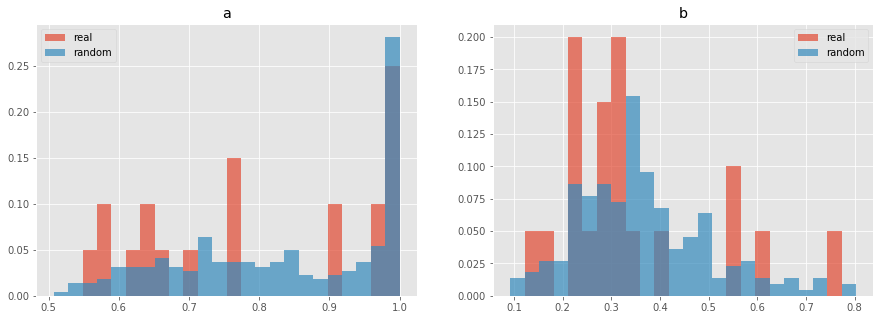

In [228]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False, figsize=(15, 5))

i = 0
for score in score_types:
    print score
    if "addition" in score or "model" not in score:
        continue
    bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 25)
    cur_ax = ax[i % 2]
    for is_random in [False, True]:
        bar_data = mean_data.loc[mean_data.is_random == is_random][score].values
        weights = np.ones_like(bar_data) / float(len(bar_data))
        cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
    cur_ax.legend(["real", "random"])
#     cur_ax.set_title(score.replace("_", " "))
    cur_ax.set_title(['a', 'b'][i])
    i += 1
plt.savefig("vertex_score_histograms.png")
plt.show()

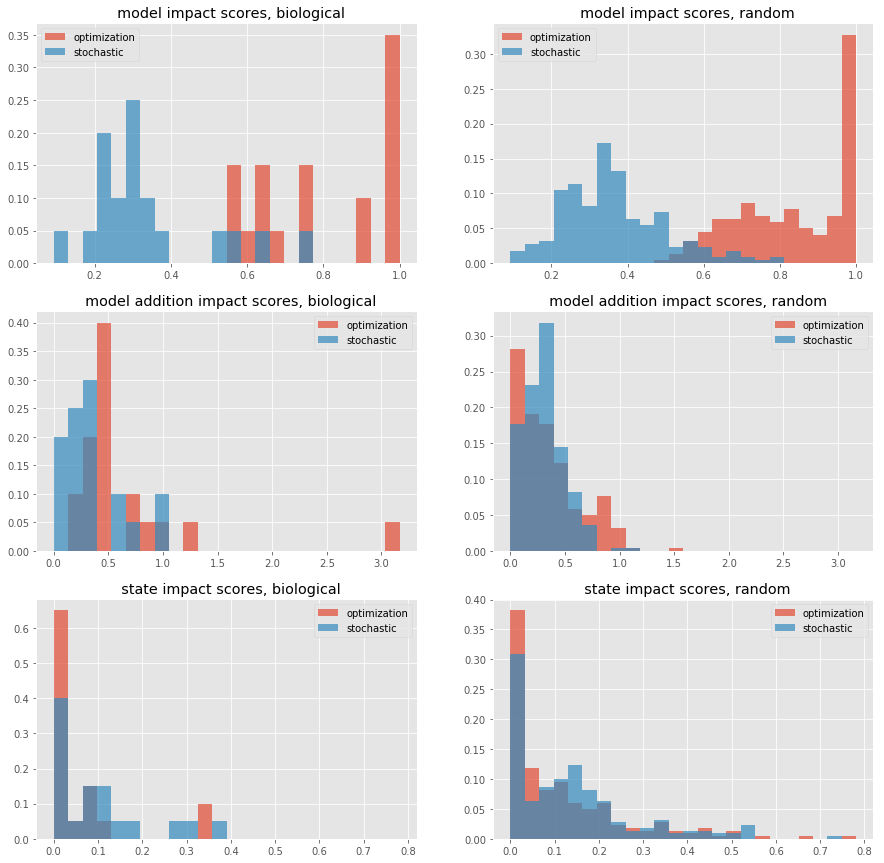

In [229]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 15))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    for is_random in [False, True]:
        bins = np.linspace(min(min(mean_data[score_pair[0]]), min(mean_data[score_pair[1]])), 
                           max(max(mean_data[score_pair[0]]), max(mean_data[score_pair[1]])), 25)
        cur_ax = ax[i / 2, i % 2]
        for score in score_pair:
            bar_data = mean_data.loc[mean_data.is_random == is_random][score].values
            weights = np.ones_like(bar_data) / float(len(bar_data))
            cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
        cur_ax.legend(["optimization", "stochastic"])
        cur_ax.set_title("{}, {}".format(score_pair[0].replace("optimization", " ").replace("_", " "), 
                                         "random" if is_random else "biological"))
        i += 1
plt.savefig("mean_score_histograms_method.png")
plt.show()

('optimization_model_impact_scores', 'stochastic_model_impact_scores') 0.20855983192009933
('optimization_model_addition_impact_scores', 'stochastic_model_addition_impact_scores') 0.04883137418317227
('optimization_state_impact_scores', 'stochastic_state_impact_scores') 0.8629320085990054


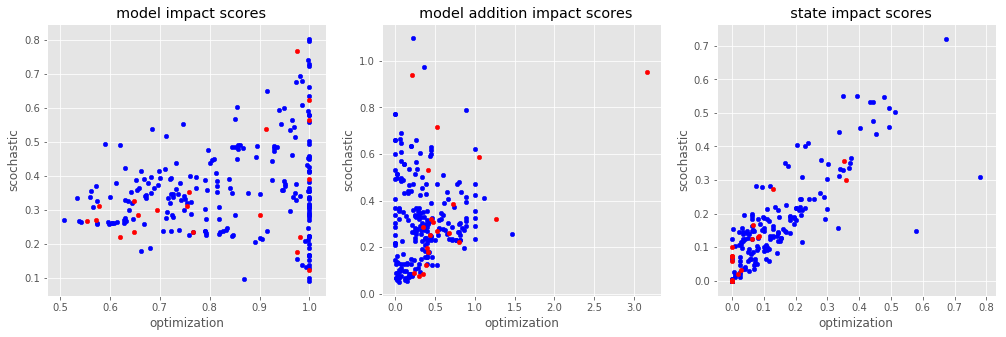

In [230]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(17, 5))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    cur_ax = ax[i]
    mean_data.loc[mean_data.is_random == True].plot.scatter(x=score_pair[0], y=score_pair[1], c="blue", ax=cur_ax)
    mean_data.loc[mean_data.is_random == False].plot.scatter(x=score_pair[0], y=score_pair[1], c="red", ax=cur_ax)
    cur_ax.set_title(score_pair[0].replace("optimization", " ").replace("_", " "))
    cur_ax.set_xlabel("optimization")
    cur_ax.set_ylabel("scochastic")
    i += 1
    print score_pair, np.corrcoef(mean_data.loc[mean_data.is_random == True][score_pair[0]], 
                                  mean_data.loc[mean_data.is_random == True][score_pair[1]])[1, 0]
plt.savefig("mean_scatter_score_types.png")
plt.show()

In [231]:
mean_pvalue_data = []
for score in score_types:
    bio = mean_data.loc[mean_data.is_random == False][score]
    rnd = mean_data.loc[mean_data.is_random == True][score]
    row = score.replace("_", " ").replace(" impact scores", ""), np.nanmean(bio), np.nanmean(rnd), stats.mannwhitneyu(bio, rnd)[1]
    mean_pvalue_data.append(row)
mean_pvalue_data = pd.DataFrame(mean_pvalue_data)
mean_pvalue_data.columns = ["impact variant", "biological mean", "random mean", "p-value (MWW test)"]
mean_pvalue_data = mean_pvalue_data.set_index(mean_pvalue_data.columns[0])
mean_pvalue_data.to_csv("mean_pvalues.csv", float_format="%.3g")
mean_pvalue_data


,biological mean,random mean,p-value (MWW test)
impact variant,,,
optimization model,0.799816,0.832963,0.195415
stochastic model,0.340358,0.364066,0.075680
optimization model addition,0.657237,0.345675,0.000521
stochastic model addition,0.355122,0.317503,0.499329
optimization state,0.059181,0.113715,0.027934
stochastic state,0.095647,0.135742,0.151631


In [232]:
bio = mean_data.loc[mean_data.is_random == False]
rnd = mean_data.loc[mean_data.is_random == True]
threshold = 0.3
for score in score_types:
    print score
    for field in [col for col in data.columns if ("scores" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float, np.int64]]:
        if np.corrcoef(bio[score], bio[field])[1,0] >= threshold or np.corrcoef(rnd[score], rnd[field])[1,0] >= threshold:
            print "{}\t biological corr={:.2f}\t random corr={:.2f}".format(field, np.corrcoef(bio[score], bio[field])[1,0], np.corrcoef(rnd[score], rnd[field])[1,0])
    print ""


optimization_model_impact_scores
mean_attractor_length	 biological corr=0.60	 random corr=0.35
median_attractor_length	 biological corr=0.61	 random corr=0.35
std_attractor_length	 biological corr=0.52	 random corr=0.07
max_attractor_length	 biological corr=0.54	 random corr=0.15
std_attractor_basin	 biological corr=0.32	 random corr=0.37
median_attractor_basin	 biological corr=0.74	 random corr=0.56
max_attractor_basin	 biological corr=0.79	 random corr=0.72

stochastic_model_impact_scores
size	 biological corr=0.46	 random corr=0.24
mean_attractor_length	 biological corr=0.68	 random corr=0.46
median_attractor_length	 biological corr=0.67	 random corr=0.43
std_attractor_length	 biological corr=0.66	 random corr=0.21
max_attractor_length	 biological corr=0.70	 random corr=0.35

optimization_model_addition_impact_scores
mean_degree	 biological corr=0.39	 random corr=-0.05
mean_attractor_length	 biological corr=0.75	 random corr=-0.30
median_attractor_length	 biological corr=0.75	 rando

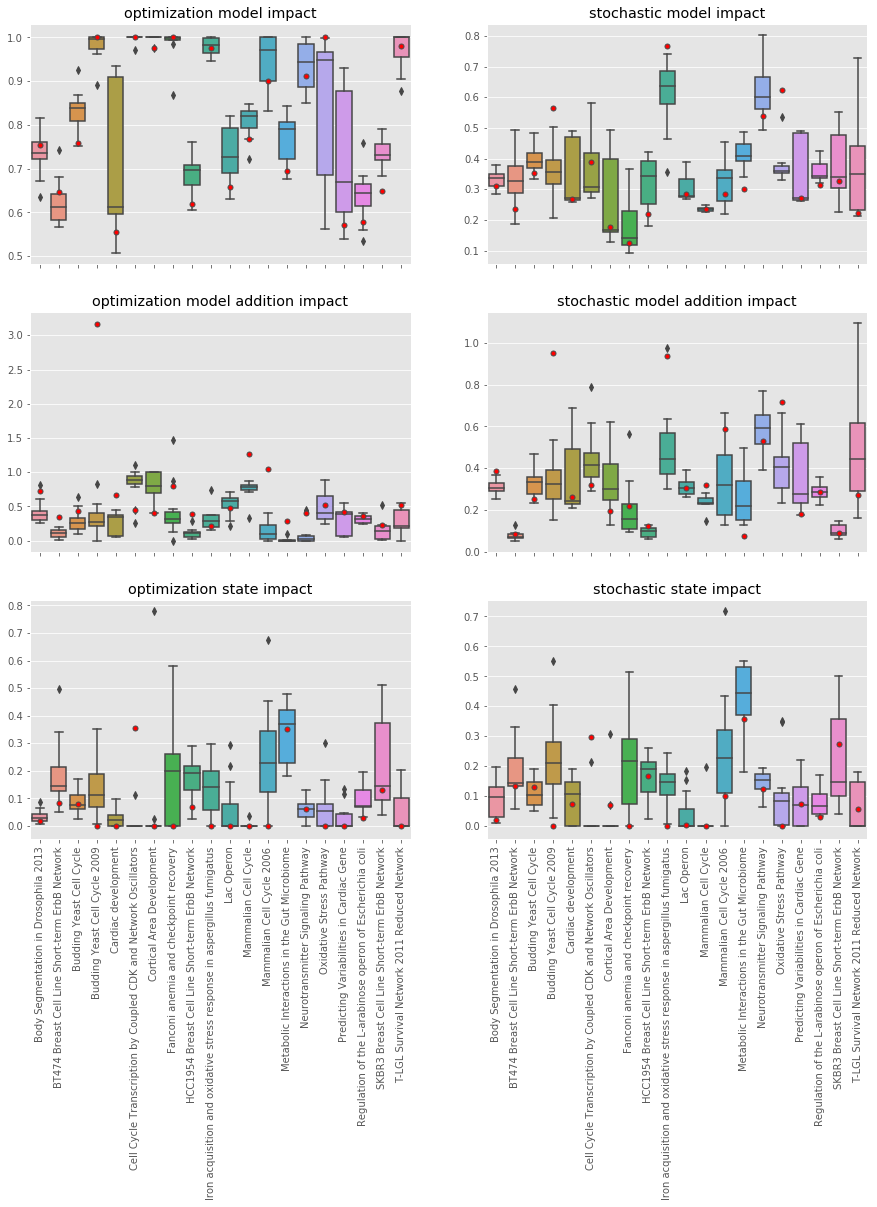

In [233]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=True, figsize=(15, 15))

i = 0
for score in score_types:
    bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 25)
    cur_ax = ax[i / 2, i % 2]
    g = seaborn.boxplot(ax=cur_ax, data=mean_data.loc[mean_data.is_random == True], 
                    x="graph_name", y=score, hue="graph_name", dodge=False)
    bio = mean_data.loc[mean_data.is_random == False]
    seaborn.swarmplot(ax=cur_ax, x="graph_name", y=score, data=bio,
              size=5, color="red", marker="o", linewidth=1)

    cur_ax.xaxis.set_tick_params(rotation=90)
    cur_ax.set_ylabel("")
    cur_ax.set_xlabel("")
    cur_ax.legend_.remove()
    cur_ax.set_title(score.replace("_", " ").replace(" scores", ""))
    i += 1
plt.savefig("mean_graph_scores.png")
plt.show()

## VERTEX

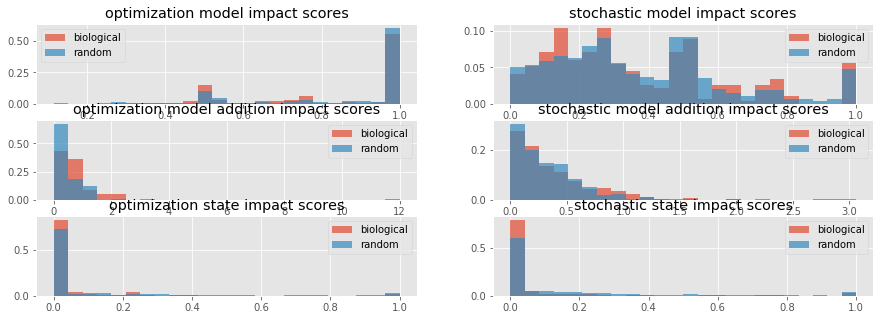

In [234]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 5))

i = 0
for score in score_types:
    bins = np.linspace(min(vertex_data[score]), max(vertex_data[score]), 25)
    cur_ax = ax[i / 2, i % 2]
#     cur_ax = ax[i % 2]
    for is_random in [False, True]:
        bar_data = vertex_data.loc[vertex_data.is_random == is_random][score].values
        weights = np.ones_like(bar_data) / float(len(bar_data))
        cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
    cur_ax.legend(["biological", "random"])
    cur_ax.set_title(score.replace("_", " "))
    i += 1
plt.savefig("vertex_score_histograms_israndom.png")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

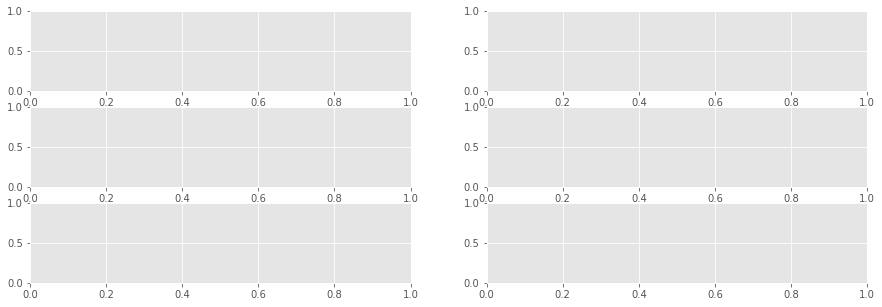

In [235]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 5))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    for is_random in [False, True]:
        bins = np.linspace(min(min(vertex_data[score_pair[0]]), min(vertex_data[score_pair[1]])), 
                           max(max(vertex_data[score_pair[0]]), max(vertex_data[score_pair[1]])), 25)
#         cur_ax = ax[i / 2, i % 2]
        cur_ax = ax[i % 2]
        for score in score_pair:
            bar_data = vertex_data.loc[vertex_data.is_random == is_random][score].values
            weights = np.ones_like(bar_data) / float(len(bar_data))
            cur_ax.hist(bar_data, alpha=0.7, bins=bins, weights=weights)
        cur_ax.legend(["optimization", "stochastic"])
        cur_ax.set_title("{}, {}".format(score_pair[0].replace("optimization", " ").replace("_", " "), 
                                         "random" if is_random else "biological"))
        i += 1
plt.savefig("vertex_score_histograms_method.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(17, 5))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    cur_ax = ax[i]
    vertex_data.loc[vertex_data.is_random == True].plot.scatter(x=score_pair[0], y=score_pair[1], c="blue", ax=cur_ax)
    vertex_data.loc[vertex_data.is_random == False].plot.scatter(x=score_pair[0], y=score_pair[1], c="red", ax=cur_ax)
    cur_ax.set_title(score_pair[0].replace("optimization", " ").replace("_", " "))
    cur_ax.set_xlabel("optimization")
    cur_ax.set_ylabel("scochastic")
    i += 1
    print score_pair
    print "biological - ", np.corrcoef(vertex_data.loc[vertex_data.is_random == False][score_pair[0]], 
                                  vertex_data.loc[vertex_data.is_random == False][score_pair[1]])[1, 0]
    print "random - ", np.corrcoef(vertex_data.loc[vertex_data.is_random == True][score_pair[0]], 
                                  vertex_data.loc[vertex_data.is_random == True][score_pair[1]])[1, 0]

plt.savefig("vertex_scatter_score_types.png")
plt.show()

In [ ]:
vertex_pvalue_data = []
for score in score_types:
    bio = vertex_data.loc[vertex_data.is_random == False][score]
    rnd = vertex_data.loc[vertex_data.is_random == True][score]
    row = score.replace("_", " ").replace(" impact scores", ""), np.nanmean(bio), np.nanmean(rnd), stats.mannwhitneyu(bio, rnd)[1]
    vertex_pvalue_data.append(row)
vertex_pvalue_data = pd.DataFrame(vertex_pvalue_data)
vertex_pvalue_data.columns = ["impact variant", "biological mean", "random mean", "p-value (MWW test)"]
vertex_pvalue_data = vertex_pvalue_data.set_index(vertex_pvalue_data.columns[0])
vertex_pvalue_data.to_csv("vertex_pvalues.csv", float_format="%.3g")
vertex_pvalue_data


In [ ]:
mean_pvalue_data = []
for score in score_types:
    bio = vertex_data.loc[vertex_data.is_random == False]
    rnd = vertex_data.loc[vertex_data.is_random == True]
    graph_names = vertex_data['graph_name'].unique()
    mean_pairs = []
    pairs = []
#     ranks = []
#     samples_per_graph = None
    for graph_name in graph_names:
        graph_bio = bio.loc[bio.graph_name == graph_name][score]
        graph_rnd = rnd.loc[rnd.graph_name == graph_name][score]
#         if samples_per_graph is None:
#             samples_per_graph = len(graph_rnd) + 1
        mean_pairs.append((graph_bio.mean(), graph_rnd.mean()))

#     pair_pvalue = stats.wilcoxon(zip(*pairs)[0], zip(*pairs)[1])[1]
    mean_pair_pvalue = stats.wilcoxon(zip(*mean_pairs)[0], zip(*mean_pairs)[1])[1]
#     rank_counts = [len([r for r in ranks if r == i]) for i in range(samples_per_graph)]
#     print rank_counts
#     rank_pvalue = stats.chisquare(f_obs=rank_counts)[1]
    row = score.replace("_", " ").replace(" impact score", ""), mean_pair_pvalue # , rank_pvalue
    mean_pvalue_data.append(row)
mean_pvalue_data = pd.DataFrame(mean_pvalue_data)
mean_pvalue_data.columns = ["impact variant", "p-value (Wilcoxon mean test)"]
#                             "p-value (Wilcoxon test)"]
                            #"p-value (rank chisquared)"]
#                             "significant ratio (sorting test)"]
mean_pvalue_data = mean_pvalue_data.set_index(mean_pvalue_data.columns[0])
# mean_pvalue_data.to_csv("mean_pvalues.csv", float_format="%.3g")
mean_pvalue_data

In [ ]:
bio = vertex_data.loc[vertex_data.is_random == False]
rnd = vertex_data.loc[vertex_data.is_random == True]
threshold = 0.3
for score in score_types:
    print score
    for field in [col for col in data.columns if ("scores" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float, np.int64]]:
        if np.corrcoef(bio[score], bio[field])[1,0] >= threshold or np.corrcoef(rnd[score], rnd[field])[1,0] >= threshold:
            print "{}\t biological corr={:.2f}\t random corr={:.2f}".format(field, np.corrcoef(bio[score], bio[field])[1,0], np.corrcoef(rnd[score], rnd[field])[1,0])
    print ""


In [ ]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=True, figsize=(15, 15))

i = 0
for score in score_types:
    bins = np.linspace(min(vertex_data[score]), max(vertex_data[score]), 25)
    cur_ax = ax[i / 2, i % 2]
    g = seaborn.boxplot(ax=cur_ax, data=vertex_data.loc[vertex_data.is_random == True], 
                    x="graph_name", y=score, hue="graph_name", dodge=False)
    
    cur_ax.xaxis.set_tick_params(rotation=90)
    cur_ax.legend_.remove()
    cur_ax.set_ylabel("")
    cur_ax.set_xlabel("")
    cur_ax.set_title(score.replace("_", " ").replace(" scores", ""))
    i += 1
plt.savefig("vertex_graph_scores.png")
plt.show()

In [ ]:
for score in score_types:
    vertex_pvalue_data = []
    for graph in vertex_data.graph_name.unique():
        bio = vertex_data.loc[(vertex_data.graph_name == graph) & (vertex_data.is_random == False)][score]
        rnd = vertex_data.loc[(vertex_data.graph_name == graph) & (vertex_data.is_random == True)][score]
        row = score.replace("_", " ").replace(" impact scores", ""), np.nanmean(bio), np.nanmean(rnd), stats.mannwhitneyu(bio, rnd)[1]
        vertex_pvalue_data.append(row)
    vertex_pvalue_data = pd.DataFrame(vertex_pvalue_data)
    vertex_pvalue_data.columns = ["impact variant", "biological mean", "random mean", "p-value (MWW test)"]
    vertex_pvalue_data = vertex_pvalue_data.set_index(vertex_pvalue_data.columns[0])
    print score
    print vertex_pvalue_data[vertex_pvalue_data.columns[-1]].median()
    print vertex_pvalue_data
# vertex_pvalue_data.to_csv("vertex_pvalues.csv", float_format="%.3g")
# vertex_pvalue_data

## Timing and graph properties

In [237]:
timing_types = [score.replace("impact_scores", "time") for score in score_types]
timing_data = []
for timing_type in timing_types:
    print timing_type
    row = [np.nanmedian(data[timing_type]), np.nanmean(data[timing_type]),
                                                         np.nanmax(data[timing_type])]
    timing_data.append([timing_type.replace("_", " ").replace(" time", "")] + row)
timing_data = pd.DataFrame(timing_data)
timing_data = timing_data.set_index(timing_data.columns[0])
timing_data.columns = ["median (seconds)", "mean (seconds)", "max (seconds)"]
timing_data.index.name = "impact variant"
timing_data.to_csv("timings.csv", float_format="%.0f")
timing_data

# bins = np.linspace(0, 4000, 100)
# for timing_type in timing_types:
#     data[timing_type].hist(figsize=(20, 12), bins=bins, alpha=0.3)
# plt.legend(timing_types)
# plt.show()

# for timing_type in timing_types:
#     for graph_name in data.graph_name.unique():
#         data.loc[data.graph_name == graph_name][timing_type].hist(figsize=(20, 12), bins=bins, alpha=0.3)
#     plt.title(timing_type)
#     plt.legend(data.graph_name.unique())
#     plt.show()

# for timing_type in timing_types:
#     for field in [col for col in data.columns if ("scores" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float, np.int64]]:
#         data.plot.scatter(field, timing_type)


optimization_model_time
stochastic_model_time
optimization_model_addition_time
stochastic_model_addition_time
optimization_state_time
stochastic_state_time


,median (seconds),mean (seconds),max (seconds)
impact variant,,,
optimization model,1.362878,3.088127,26.732371
stochastic model,1378.625914,1720.275679,7043.028339
optimization model addition,99.993842,288.020783,4266.760450
stochastic model addition,1506.827890,1828.203960,7891.154656
optimization state,158.021152,892.862811,8646.752806
stochastic state,12.782863,17.002244,71.894509


In [238]:
bio_properties = data.loc[data.is_random==False][[col for col in data.columns if (col not in score_types) and (
    col not in timing_types) and (col not in ["is_random", "maximal_change_bits"])]]
rnd_properties = data.loc[data.is_random==True][[col for col in data.columns if (col not in score_types) and (
    col not in timing_types) and (col not in ["is_random", "maximal_change_bits"])]]
bio_properties.to_csv("graph_properties.csv", float_format='%.3g')
bio_properties

,graph_name,size,n_inputs,normalized_n_inputs,max_degree,mean_degree,num_attractors,mean_attractor_length,median_attractor_length,std_attractor_length,max_attractor_length,std_attractor_basin,median_attractor_basin,max_attractor_basin
4,Body Segmentation in Drosophila 2013,17,3,0.176471,4,1.705882,10,1.00000,1.0,0.000000,1,0.046362,0.118468,0.137838
6,BT474 Breast Cell Line Short-term ErbB Network,16,5,0.312500,6,2.875000,86,1.00000,1.0,0.000000,1,0.012272,0.003180,0.042130
7,Budding Yeast Cell Cycle,20,4,0.200000,6,2.100000,32,1.87500,1.0,1.815730,11,0.021304,0.028936,0.077872
8,Budding Yeast Cell Cycle 2009,18,0,0.000000,6,3.277778,1,11.00000,11.0,0.000000,11,0.000000,1.000000,1.000000
9,Cardiac development,15,1,0.066667,7,2.533333,5,1.00000,1.0,0.000000,1,0.095619,0.247423,0.259941
10,Cell Cycle Transcription by Coupled CDK and Ne...,9,0,0.000000,4,2.111111,2,3.00000,3.0,2.000000,5,0.257174,0.500000,0.757174
11,Cortical Area Development,5,0,0.000000,4,2.800000,2,1.00000,1.0,0.000000,1,0.375000,0.500000,0.875000
12,Fanconi anemia and checkpoint recovery,15,0,0.000000,8,4.400000,1,2.00000,2.0,0.000000,2,0.000000,1.000000,1.000000
13,HCC1954 Breast Cell Line Short-term ErbB Network,16,5,0.312500,6,2.875000,78,1.00000,1.0,0.000000,1,0.013416,0.003082,0.043914
15,Iron acquisition and oxidative stress response...,22,2,0.090909,6,1.727273,4,5.50000,5.5,3.500000,9,0.003024,0.250231,0.253932


In [ ]:
print "median num attractors:\t bio={:.2f}, rnd={:.2f}".format(np.median(bio_properties['num_attractors']), 
                                                                np.median(rnd_properties['num_attractors']))
print "mean num attractors:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['num_attractors']), 
                                                                np.mean(rnd_properties['num_attractors']))
print "average average attractor length:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['mean_attractor_length']), 
                                                                np.mean(rnd_properties['mean_attractor_length']))
print "average median attractor basin:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['median_attractor_basin']), 
                                                                np.mean(rnd_properties['median_attractor_basin']))
print "average max attractor basin:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['max_attractor_basin']), 
                                                                np.mean(rnd_properties['max_attractor_basin']))


## JUNK

In [332]:
biological_graphs = []
biological_graph_names = []
candidate_biological_graph_names = os.listdir("cellcollective_models")
for graph_dir in candidate_biological_graph_names:
    try:
        G = graphs.Network.parse_boolean_tables(os.path.join("cellcollective_models", graph_dir))
        biological_graphs.append(G)
        biological_graph_names.append(graph_dir)
    except ValueError as e:
        if e.message.startswith("Model export from cellcollective failed"):
            print "warning - did not load graph {}".format(graph_dir)

graph_name_to_attributes = dict()
for i, graph, name in zip(range(len(biological_graphs)), biological_graphs, biological_graph_names):
    n_inputs = len([v for v in graph.vertices if len(v.predecessors()) == 0])
    max_degree = max([len(v.predecessors()) for v in graph.vertices])
    size = len(graph.vertices)
    mean_degree = sum([len(v.predecessors()) for v in graph.vertices]) / float(size)
    normaliezd_n_inputs = n_inputs / float(size)
    graph_name_to_attributes[name] = dict(n_inputs=n_inputs, max_degree=max_degree,
                                                size=size, mean_degree=mean_degree,
                                          normalized_n_inputs=normaliezd_n_inputs, G=graph)
    print "#{}; {} input nodes for graph {} of size {} and max degree {}".format(i, n_inputs, name,
                                                                                 size, max_degree)


KeyboardInterrupt: 

16 57


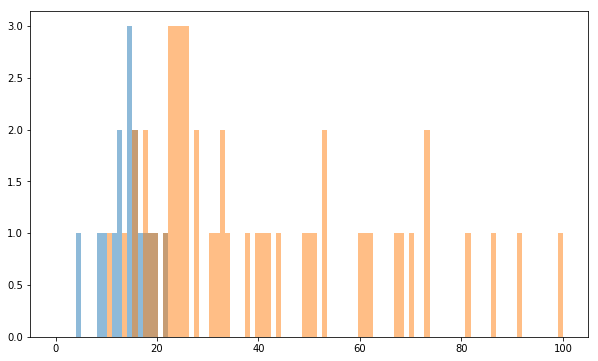

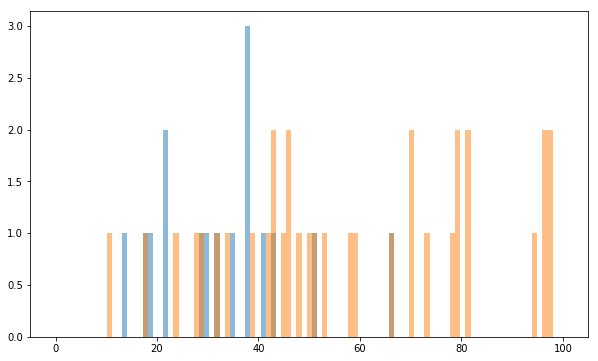

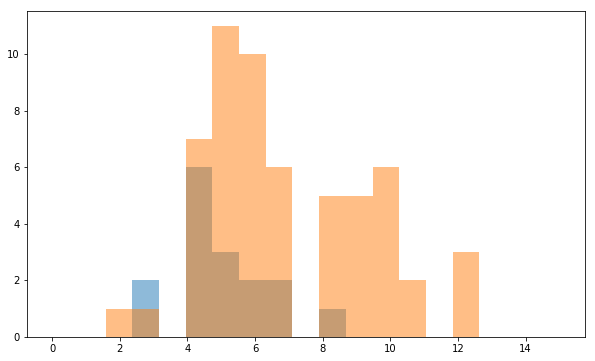

In [ ]:
good_graphs = [name for name in graph_name_to_attributes.keys() if name in data["graph_name"].unique()]
bad_graphs = [name for name in graph_name_to_attributes.keys() if name not in good_graphs]
print len(good_graphs), len(bad_graphs)

good_sizes = [graph_name_to_attributes[name]['size'] for name in good_graphs]
bad_sizes = [graph_name_to_attributes[name]['size'] for name in bad_graphs]
bins = np.linspace(0, 100, 100)
plt.hist(good_sizes, alpha=0.5, bins=bins)
plt.hist(bad_sizes, alpha=0.5, bins=bins)
plt.show()

good_edges = [graph_name_to_attributes[name]['size'] * graph_name_to_attributes[name]['mean_degree'] for name in good_graphs]
bad_edges = [graph_name_to_attributes[name]['size'] * graph_name_to_attributes[name]['mean_degree'] for name in bad_graphs]
bins = np.linspace(0, 100, 100)
plt.hist(good_edges, alpha=0.5, bins=bins)
plt.hist(bad_edges, alpha=0.5, bins=bins)
plt.show()

good_edges = [graph_name_to_attributes[name]['max_degree'] for name in good_graphs]
bad_edges = [graph_name_to_attributes[name]['max_degree'] for name in bad_graphs]
bins = np.linspace(0, 15, 20)
plt.hist(good_edges, alpha=0.5, bins=bins)
plt.hist(bad_edges, alpha=0.5, bins=bins)
plt.show()

good_attractors = [len(stochastic.estimate_attractors(
    G=graph_name_to_attributes[name]['G'], max_walk_len=50, n_walks=200, with_basins=False)) for name in good_graphs]
bad_attractors = [len(stochastic.estimate_attractors(
    G=graph_name_to_attributes[name]['G'], max_walk_len=50, n_walks=200, with_basins=False)) for name in bad_graphs if graph_name_to_attributes[name]['size'] <= 10000]
bins = np.linspace(0, 100, 100)
plt.hist(good_attractors, alpha=0.5, bins=bins)
plt.hist(bad_attractors, alpha=0.5, bins=bins)
plt.show()